# Plots report

In [205]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

setup_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
DATA_PATH = '../data/'
quotation = 'AAPL'
FILE_SUFFIX = '.txt'
price_column = 'Close'

In [207]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}")
data_wrapper.compute_features(predict_n=1, thresh_diff=0.005)
data_wrapper.head()

,Date,Open,High,Low,Close,Volume,Adjusted,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,2007-02-21,3.070714,3.196071,3.070000,3.185714,1.155314e+09,2.748159,0.000714,60.880791,0.002857,...,3.055786,3.051339,3.068233,0.018074,-0.004446,0.117857,0.038417,higher,3.196786,stay
1,2007-02-22,3.242857,3.243214,3.161786,3.196786,8.382248e+08,2.757710,0.035000,61.709592,0.057143,...,3.067786,3.056357,3.085373,0.017140,-0.011429,0.011072,0.003476,stay,3.181072,stay
2,2007-02-23,3.184286,3.226429,3.173214,3.181072,5.178936e+08,2.744154,0.007858,59.773981,0.012500,...,3.078107,3.061393,3.098133,0.012760,-0.016714,-0.015714,-0.004916,stay,3.161072,lower
3,2007-02-26,3.208571,3.214286,3.128929,3.161072,6.158488e+08,2.726901,0.032143,57.310074,0.027499,...,3.096822,3.066982,3.106525,0.008392,-0.029839,-0.020000,-0.006287,lower,2.997500,lower
4,2007-02-27,3.082143,3.110000,2.978929,2.997500,1.145813e+09,2.585796,0.018571,42.045227,0.078929,...,3.093429,3.063393,3.091988,-0.014537,-0.030036,-0.163572,-0.051746,lower,3.021786,higher


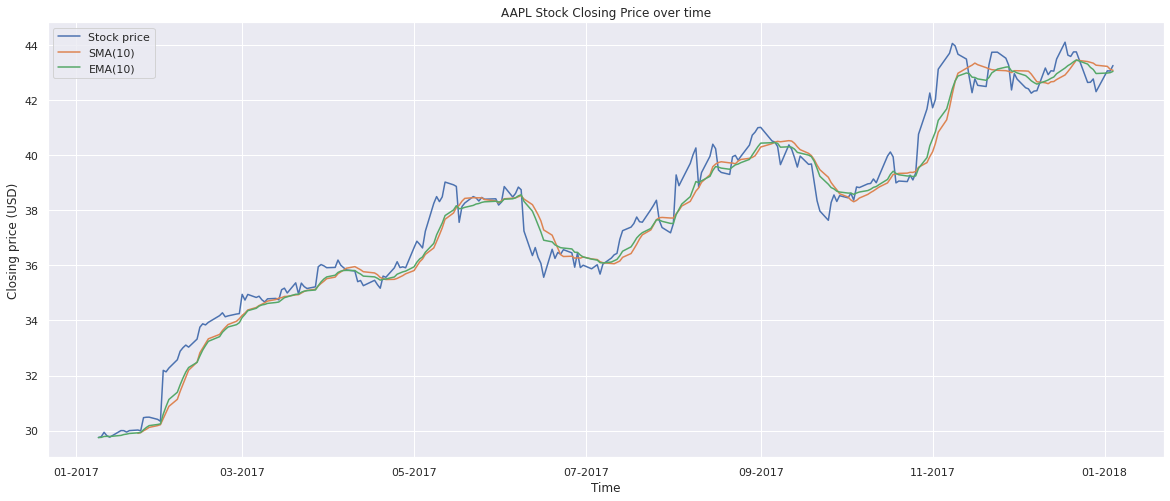

In [208]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'][-250:], data_wrapper[price_column][-250:], quotation_name=quotation, ma_values=[10], ema_values=[10])

In [209]:
quotations = ['AAL', 'AAPL', 'AMZN','CMCSA', 'COST', 'GM', 'GOOG', 'IBM', 'JNJ', 'KO','PEP', 'TSLA', 'WMT', 'XOM']

trading_windows = {
    'day':1,
    'week':5,
    'month':21,
    'year':252,
}

with open("volatility_output.csv", 'w') as f:
    for quot in quotations:
        data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}")
        data_wrapper.compute_features(predict_n=1, thresh_diff=0.005)
        daily_volatility = data_wrapper['Close'].pct_change(1).std()

        f.write(f"{quot},")
        for label, w in trading_windows.items():
            f.write(f"{(daily_volatility * w ** 0.5):.3f} ,")

        f.write('\n')
        

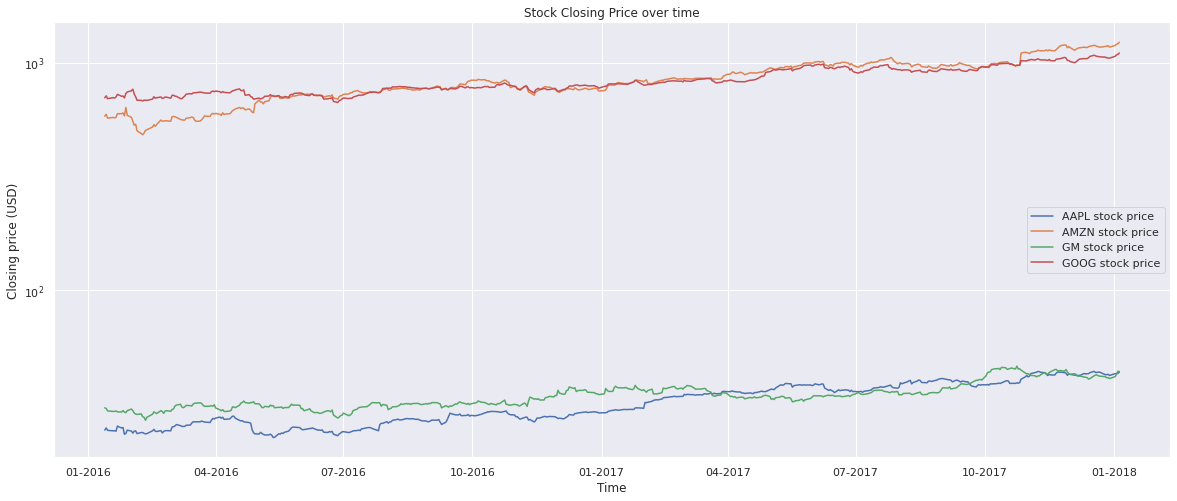

In [210]:
import matplotlib.dates as mdates
import datetime

prices_dict = {}
n_days = 500
for quot in ['AAPL', 'AMZN', 'GM', 'GOOG']:
    data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}")
    prices_dict[quot] = data_wrapper['Close'][-n_days:]
    
date_series = data_wrapper['Date'][-n_days:]        
ax = plt.gca()
ax.set(yscale='log')
ax.set(title=f"Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')
x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in date_series]

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

for quot, prices in prices_dict.items():
    ax.plot(x_values, prices, label=f"{quot} stock price")

    
    
plt.legend(loc='center right')
plt.show()


In [275]:
days_predict_feature_set = {
    1:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band', 'GAP', 'MACD_diff'],
    5:['Volume', 'Close', 'LowLen', 'Difference', 'SMA(20) - SMA(10)', 'BG_H_Band_Indicator', 'MACD'],
    10:['Volume', 'Close', 'BodyLen', 'Difference', 'SMA(20) - SMA(10)', 'EMA_Diff', 'MACD_diff'],
    20:['Volume', 'Close', 'LowLen', 'Difference', 'EMA(14)', 'BG_H_Band', 'MACD_diff'],
    50:['Volume', 'Close', 'LowLen', 'Difference', 'BG_L_Band','GAP','MACD_diff'],
}

In [276]:
quot = 'AAL'
predict_n = 20

In [277]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [278]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quot}{FILE_SUFFIX}", compute_features=True, 
                                           predict_n=predict_n, thresh_diff=None, normalize=True)


X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2, 
                                                             y_column='NextPrice', 
                                                             features_list=days_predict_feature_set[predict_n])



reg = LinearRegression(normalize=False, fit_intercept=True)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

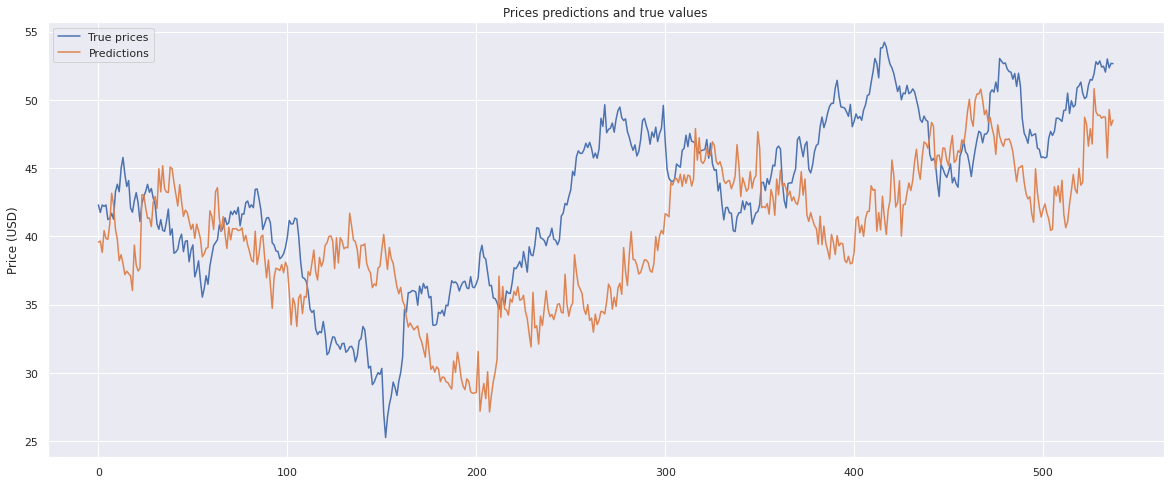

In [279]:
from helpers.plots_helper import plot_predictions

scaled_preds = data_wrapper.get_unscaled_values(y_pred, 'Close')
scaled_labels = data_wrapper.get_unscaled_values(y_test, 'Close')

plot_predictions(scaled_labels, scaled_preds)
plt.show()

In [280]:
seq_len = 5
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_regression_trainer import KerasRegressionTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=days_predict_feature_set[predict_n],
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 100,
    n_splits = 5,
    val_size = 0.2,
)

In [281]:
X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.2,
                                                             y_column='NextPrice', sequences=True, seq_len=5,
                                                             features_list=days_predict_feature_set[predict_n])
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

model = LSTMModel(config_dict, seq_len, len(days_predict_feature_set[predict_n]), output_dim=1,
                  learning_rate=config_dict['learning_rate'], loss='mae', metrics=['accuracy'])
trainer = KerasRegressionTrainer(model, use_wandb=True, project_label="PlotsReport")
trainer.train(train_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/PlotsReport/runs/3pc0fr5e


{}

In [282]:
y_pred = model.predict(X_test)

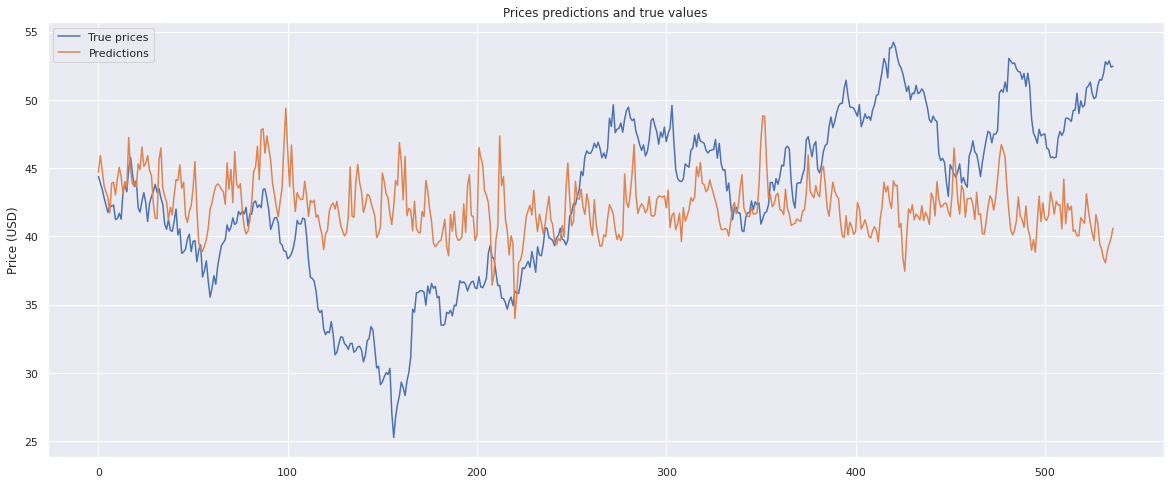

In [283]:
from helpers.plots_helper import plot_predictions

scaled_preds = data_wrapper.get_unscaled_values(y_pred.squeeze(), 'Close')
scaled_labels = data_wrapper.get_unscaled_values(y_test, 'Close')

plot_predictions(scaled_labels, scaled_preds)
plt.show()